<a href="https://colab.research.google.com/github/00150/AI_07_JYP_Project_section_02/blob/main/Used_car_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
# 필요한 라이브러리를 설치합니다.
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.8 MB/s eta 0:00:00


In [114]:
# 모델링을 진행할 데이터를 가져옵니다.
# 필요한 라이브러 및 패키지는 그때 그때 가져오도록 합니다.
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/00150/AI_07_JYP_Project_section_02/main/audi_eda').drop('Unnamed: 0', axis = 1)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9345 entries, 0 to 9344
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          9345 non-null   object 
 1   year           9345 non-null   int64  
 2   price          9345 non-null   int64  
 3   transmission   9345 non-null   object 
 4   mileage        9345 non-null   int64  
 5   fuelType       9345 non-null   object 
 6   tax            9345 non-null   int64  
 7   mpg            9345 non-null   float64
 8   engineSize     9345 non-null   float64
 9   size_and_type  9345 non-null   object 
 10  size           9345 non-null   object 
 11  type           9344 non-null   object 
 12  used_year      9345 non-null   int64  
 13  ampy           9345 non-null   float64
 14  km/l           9345 non-null   float64
dtypes: float64(4), int64(5), object(6)
memory usage: 1.1+ MB


앞서 EDA & Visualization 을 진행한 데이터에는 다음과 같은 컬럼이 존재합니다.

* 각각의 컬럼은 다음과 같습니다. 
  - model : 자동차의 모델명 
  - year : 연식 
  - price : 가격 
  - transmission : 변속기
  - mileage : 자동차 주행거리
  - fuelType : 자동차 연료의 유형
  - tax : 세금(자동차)
  - mpg(Miles per Gallon) : 자동차 연비(Fuel efficiency)
  - engineSize :엔진 크기
  - size_and_type :차량의 사이즈 및 타입
  - size : 차량의 사이즈
  - type : 차량의 유형
  - used_year : 차를 사용한 연도
  - ampy : 연간 평균 주행거리.
  - km/l : 자동차 연비(한국식 표현)

In [116]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,size_and_type,size,type,used_year,ampy,km/l
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,small_hatchback,small,hatchback,6,2622.5,23.8
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,subfull_sedan,subfull,sedan,7,5171.9,27.6
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,small_hatchback,small,hatchback,7,4278.0,23.8
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,mid_sedan,mid,sedan,6,4325.3,28.9
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,submid_hatchback,submid,hatchback,4,499.5,21.3


##1. Feature Engineering
> 기존 데이터에서 추가로 이용할 수 있는 부분이 있다면 새로운 피처를 생성합니다.

 -  Good preference badge 추가하기. <br>
 차량을 사용한 이력이 3~5년사이, 주행거리가 30000이하, 자동차 연비(기준:km/l)가 21 이상이라면 뱃지를 달아줍니다.

 - 차량 모델에 상관없이 상태가 좋은 중고차를 구매하려고 하는 사람들이 분명 존재합니다. <br/>
   이들에게 추천해줄 수 있도록 분류하는 모델을 생성하고자 합니다.



In [117]:
# np.select() method를 이용합니다.
import numpy as np
conditionlist = [(df['used_year'] <=5) & (df['mileage'] <=30000) & (df['km/l'] >=21)]
select_data = ['good']

df['good_badge']  = np.select(conditionlist, select_data, default = 'Not Specified')

Not Specified    0.880257
good             0.119743
Name: good_badge, dtype: float64


<AxesSubplot:xlabel='good_badge', ylabel='count'>

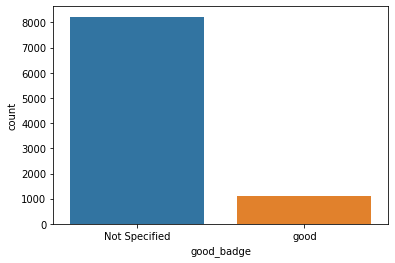

In [118]:
# 타겟 비율 확인
print(df['good_badge'].value_counts(normalize=True))

# 시각화 - 필요한 라이브러리 가져오기.
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = df['good_badge'])

현재 타겟은 **불균형한 데이터 값**을 보여주고 있습니다.
* 모델 생성시 이 부분에 유의하여 모델을 생성하도록 합니다.

#2.  Modeling

#### 2-1. Baseline 생성.
>기준모델로 최다 비율 클래스를 사용할 경우 정확도는 다음과 같습니다.

In [119]:
# 타겟값을 mapping 하도록 합니다.
# Not Specified = 0, good = 1
y_train = df['good_badge'].replace(['Not Specified', 'good'], [0,1])

# 기준 모델 생성 - 필요한 라이브러리 가져오기.
from sklearn.metrics import accuracy_score

major = y_train.mode()[0]
major

0

In [120]:
# 기준 모델 생성 - 필요한 라이브러리 가져오기.
from sklearn.metrics import accuracy_score

# 최다빈도 값 : 0이 담긴 리스트를 생성합니다. 
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

# 기준모델의 정확도는 다음과 같습니다.
print(f'baseline accuracy:{accuracy_score(y_train, y_pred)}')

baseline accuracy:0.8802568218298555


####2-2. ML 생성

In [121]:
df.columns.tolist()

['model',
 'year',
 'price',
 'transmission',
 'mileage',
 'fuelType',
 'tax',
 'mpg',
 'engineSize',
 'size_and_type',
 'size',
 'type',
 'used_year',
 'ampy',
 'km/l',
 'good_badge']

In [130]:
# 데이터 분할.
from sklearn.model_selection import train_test_split

# 타겟 데이터를 같은 비율로 분할합니다.
X_train, X_val = train_test_split(df,
                                  train_size = 0.75,
                                  stratify = df['good_badge'],random_state = 42)


# target & feature 지정
target = ['good_badge']
feature = ['model','year','price','transmission','mileage','fuelType','tax','engineSize','size','type','used_year','ampy','km/l']

# train
y_train = X_train[target]
X_train = X_train[feature]

# val
y_val = X_val[target]
X_val = X_val[feature]

# shap
print(X_train.shape,'\n', X_val.shape)
print(y_train.value_counts(normalize=True),'\n', y_val.value_counts(normalize=True))

(7008, 13) 
 (2337, 13)
good_badge   
Not Specified    0.88028
good             0.11972
dtype: float64 
 good_badge   
Not Specified    0.880188
good             0.119812
dtype: float64


In [133]:
# 데이터 인코딩 진행 : 필요한 라이브러리 가져오기.
from category_encoders import OrdinalEncoder

# 객체 인스턴스 생성.
enc = OrdinalEncoder()
X_train_encoded = enc.fit_transform(X_train)
X_val_encoded = enc.transform(X_val)

# XGBoost 필요한 라이브러리 가져오기.
from xgboost import XGBClassifier
model = XGBClassifier(
    objective = 'binary:logistic',
    eval_matric = 'auc',
    n_estimators =1000,
    random_state = 42,
    n_jobs = -1,
    max_depth = 5,
    learning_rate = 0.1,
    early_stopping_rounds = 20
)

print(model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_matric='auc', eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)
